Скошення до логарифмування:
Inventory_Balance_Food_Service           2.380043
Turnover_Food_Service                    2.622283
Gross_Margin_Store                       1.227327
Inventory_Turnover_Ratio_Food_Service    2.448384
Number_of_Receipts_Food_Service          3.168045
dtype: float64
Скошення після логарифмування:
log_Inventory_Balance_Food_Service    -0.001590
log_Turnover_Food_Service             -0.523374
winsorized_log_ITR_FS                 -0.391831
log_Number_of_Receipts_Food_Service   -0.646997
dtype: float64
                          PanelOLS Estimation Summary                           
Dep. Variable:     Gross_Margin_Store   R-squared:                        0.7297
Estimator:                   PanelOLS   R-squared (Between):              0.8851
No. Observations:                2470   R-squared (Within):               0.7297
Date:                Mon, May 05 2025   R-squared (Overall):              0.8740
Time:                        15:56:11   Log-likelihood          

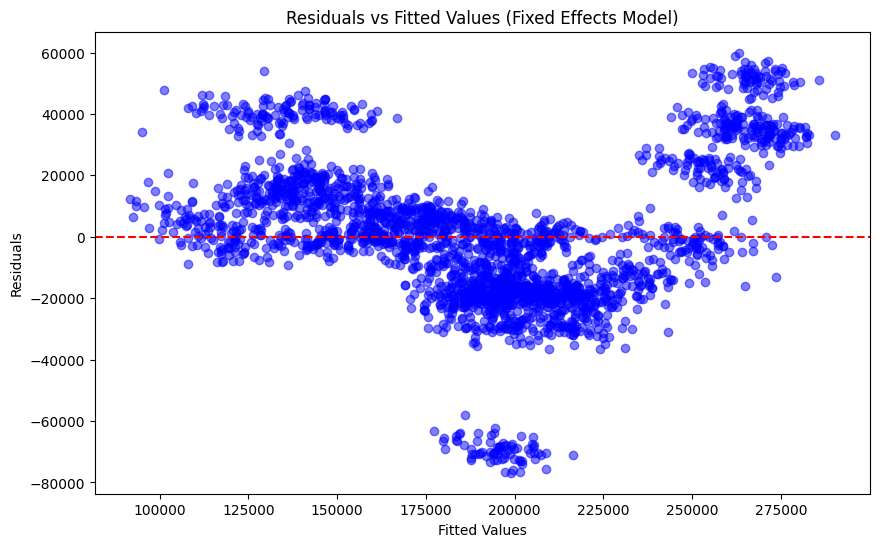

Durbin-Watson Statistic (Fixed Effects Model): 0.8132


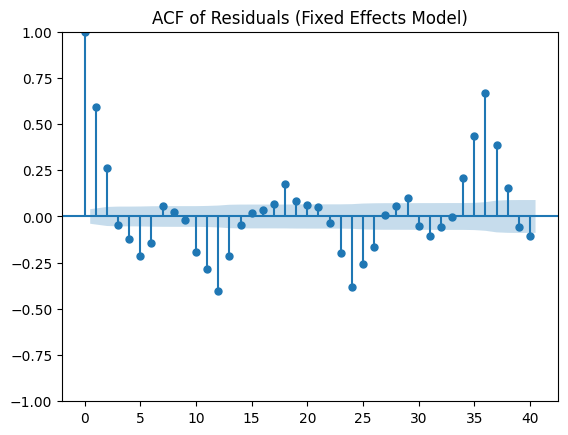

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from linearmodels.panel import PanelOLS, RandomEffects, compare
from scipy.stats.mstats import winsorize
from scipy import stats
import numpy.linalg as la
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf

df = pd.read_csv("school1.csv", delimiter=";")

df.rename(
    columns={"2022_Dummy": "Dummy_2022", "2023_Dummy": "Dummy_2023"}, inplace=True
)

cols_to_fix = [
    "Gross_Margin_Store",
    "Inventory_Balance_Food_Service",
    "Inventory_Turnover_Ratio_Food_Service",
    "Number_of_Receipts_Food_Service",
    "Turnover_Food_Service",
    "Vacation_Time",
    "Area",
    "Competitor_Presence",
    "Dummy_2022",
    "Dummy_2023",
    "February_Dummy",
    "Murch_Dummy",
    "April_Dummy",
    "May_Dummy",
    "June_Dummy",
    "July_Dummy",
    "August_Dummy",
    "September_Dummy",
    "October_Dummy",
    "November_Dummy",
    "December_Dummy",
    "School_Dummy",
    "Office_Dummy",
]

for col in cols_to_fix:
    df[col] = df[col].astype(str).str.replace(",", ".").astype(float)

skewness = df[
    [
        "Inventory_Balance_Food_Service",
        "Turnover_Food_Service",
        "Gross_Margin_Store",
        "Inventory_Turnover_Ratio_Food_Service",
        "Number_of_Receipts_Food_Service",
    ]
].skew()
print("Скошення до логарифмування:")
print(skewness)

winsorized_data = winsorize(
    df["Inventory_Turnover_Ratio_Food_Service"].dropna(), limits=[0.05, 0.05]
)
df["winsorized_log_ITR_FS"] = np.log(winsorized_data[winsorized_data > 0])

df["log_Inventory_Balance_Food_Service"] = np.where(
    df["Inventory_Balance_Food_Service"] > 0,
    np.log(df["Inventory_Balance_Food_Service"]),
    np.nan,
)

df["log_Turnover_Food_Service"] = np.where(
    df["Turnover_Food_Service"] > 0, np.log(df["Turnover_Food_Service"]), np.nan
)

df["log_Number_of_Receipts_Food_Service"] = np.where(
    df["Number_of_Receipts_Food_Service"] > 0,
    np.log(df["Number_of_Receipts_Food_Service"]),
    np.nan,
)

log_skewness = df[
    [
        "log_Inventory_Balance_Food_Service",
        "log_Turnover_Food_Service",
        "winsorized_log_ITR_FS",
        "log_Number_of_Receipts_Food_Service",
    ]
].skew()
print("Скошення після логарифмування:")
print(log_skewness)

df["Data"] = pd.to_datetime(df["Data"], dayfirst=True, errors="coerce")
df = df.set_index(["Store_ID", "Data"])

fe_model = PanelOLS.from_formula(
    "Gross_Margin_Store ~ log_Inventory_Balance_Food_Service + "
    "winsorized_log_ITR_FS + "
    "Dummy_2022 + Dummy_2023 + February_Dummy + Murch_Dummy + April_Dummy + May_Dummy + "
    "June_Dummy + July_Dummy + August_Dummy + September_Dummy + October_Dummy + November_Dummy + December_Dummy + EntityEffects",
    data=df,
)
fe_results = fe_model.fit(cov_type="clustered", cluster_entity=True)
print(fe_results.summary)

re_model = RandomEffects.from_formula(
    "Gross_Margin_Store ~ log_Inventory_Balance_Food_Service + "
    "winsorized_log_ITR_FS + Area + Competitor_Presence + "
    "Dummy_2022 + Dummy_2023 + February_Dummy + Murch_Dummy + April_Dummy + May_Dummy + June_Dummy + "
    "July_Dummy + August_Dummy + September_Dummy + October_Dummy + November_Dummy + December_Dummy",
    data=df,
)
re_results = re_model.fit(cov_type="clustered", cluster_entity=True)
print(re_results)
print(compare({"FE": fe_results, "RE": re_results}))

def hausman(fe, re):
    in_both_coef = fe.params.index.intersection(re.params.index)
    b = fe.params[in_both_coef]
    B = re.params[in_both_coef]
    v_b = fe.cov.loc[in_both_coef, in_both_coef]
    v_B = re.cov.loc[in_both_coef, in_both_coef]
    diff = b - B
    stat = float(diff.T @ la.inv(v_b - v_B) @ diff)
    d_f = len(diff)
    pval = stats.chi2.sf(stat, d_f)
    return stat, d_f, pval

chi2, df_n, pval = hausman(fe_results, re_results)
print(f"Hausman chi²: {chi2:.4f}")
print(f"Degrees of freedom: {df_n}")
print(f"p-value: {pval:.4f}")

if pval < 0.05:
    print("Conclusion: Reject H₀ and Use Fixed Effects")
else:
    print("Conclusion: Fail to reject H₀ so Random Effects acceptable")

fe_residuals = fe_results.resids

plt.figure(figsize=(10, 6))
plt.scatter(re_results.fitted_values, fe_residuals, color="blue", alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs Fitted Values (Fixed Effects Model)")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()

dw_stat_re = durbin_watson(fe_residuals)
print(f"Durbin-Watson Statistic (Fixed Effects Model): {dw_stat_re:.4f}")

plot_acf(fe_residuals, lags=40)
plt.title("ACF of Residuals (Fixed Effects Model)")
plt.show()

In [68]:
import pandas as pd
from linearmodels.panel import PanelOLS
import numpy as np
from statsmodels.stats.stattools import durbin_watson

df["log_GMP_L1"] = df.groupby(level=0)["Gross_Margin_Store"].shift(
    1
)

exog_vars = [
    "log_GMP_L1",
    "log_Turnover_Food_Service",
    "Dummy_2022",
    "Dummy_2023",
    "February_Dummy",
    "Murch_Dummy",
    "April_Dummy",
    "May_Dummy",
    "June_Dummy",
    "July_Dummy",
    "August_Dummy",
    "September_Dummy",
    "October_Dummy",
    "November_Dummy",
    "December_Dummy",
]

df_model = df.dropna(subset=exog_vars + ["Gross_Margin_Store"])

mod = PanelOLS.from_formula(
    "Gross_Margin_Store ~ " + " + ".join(exog_vars) + " + EntityEffects",
    data=df_model,
)
res = mod.fit(cov_type="clustered", cluster_entity=True)

print(res.summary)
residuals = res.resids
dw_stat = durbin_watson(residuals)
print(f"\nDurbin-Watson statistic: {dw_stat:.4f}")

if dw_stat < 1.5:
    print("Сильна позитивна автокореляція")
elif dw_stat > 2.5:
    print("Сильна негативна автокореляція")
else:
    print("Незначна автокореляція")

                          PanelOLS Estimation Summary                           
Dep. Variable:     Gross_Margin_Store   R-squared:                        0.8498
Estimator:                   PanelOLS   R-squared (Between):              0.9045
No. Observations:                2382   R-squared (Within):               0.8498
Date:                Mon, May 05 2025   R-squared (Overall):              0.8926
Time:                        15:52:45   Log-likelihood                 -2.67e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      861.19
Entities:                          83   P-value                           0.0000
Avg Obs:                       28.699   Distribution:                 F(15,2284)
Min Obs:                       1.0000                                           
Max Obs:                       35.000   F-statistic (robust):          4.263e+04
                            